In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import joblib
import os

# Model Regression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Metrics & Preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

# Konfigurasi Tampilan
pd.set_option('display.max_columns', 100)
plt.style.use('seaborn-v0_8')

In [2]:
# 1. LOAD DATA
# Pastikan file ini adalah hasil akhir dari Feature Engineering Anda
file_path = '../data/processed/master_data_modeled.csv'
df = pd.read_csv(file_path, parse_dates=['date'])

print(f"✅ Data Dimuat: {len(df)} baris")

# 2. DEFINISI FITUR & TARGET
# Target Regresi: Waktu dalam detik
target_col = 'time_seconds'

# 2. Tentukan Fitur
# Pastikan membuang kolom string/objek yang tidak bisa di-scale
drop_cols = ['race_id', 'date', 'rank', 'target_win', 'target_top3', 'horse_no', 'horse_name', 'time_seconds'] 
# Catatan: Tambahkan kolom lain yang bukan angka jika masih error
feature_cols = [c for c in df.columns if c not in drop_cols and df[c].dtype in ['int64', 'float64', 'int32', 'float32']]

print(f"Fitur: {len(feature_cols)} kolom")

# 3. TIME SERIES SPLIT
val_start_date = '2019-01-01'
test_start_date = '2020-01-01'

train_df = df[df['date'] < val_start_date].copy()
val_df = df[(df['date'] >= val_start_date) & (df['date'] < test_start_date)].copy()
test_df = df[df['date'] >= test_start_date].copy()

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

# Siapkan X dan y
X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_val = val_df[feature_cols]
y_val = val_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

✅ Data Dimuat: 1561206 baris
Fitur: 24 kolom
Train: 1441935 | Val: 45635 | Test: 73636


In [3]:
def evaluate_ranking_accuracy(model, X, df_original, dataset_name="Test"):
    """
    Mengubah prediksi waktu menjadi prediksi ranking per race.
    """
    # 1. Prediksi Waktu
    pred_time = model.predict(X)
    
    # 2. Gabungkan hasil prediksi ke DataFrame sementara
    temp_df = df_original.copy()
    temp_df['pred_time'] = pred_time
    
    # 3. Hitung Akurasi per Race
    top1_correct = 0
    top3_correct = 0
    total_races = 0
    
    unique_races = temp_df['race_id'].unique()
    
    for race in unique_races:
        race_data = temp_df[temp_df['race_id'] == race]
        
        # Urutkan kuda berdasarkan PREDIKSI WAKTU TERCEPAT (Ascending)
        # Kuda dengan waktu terendah diprediksi juara 1
        race_data_sorted = race_data.sort_values('pred_time', ascending=True)
        
        # Ambil Kuda Prediksi Juara 1 (Baris pertama setelah sort)
        pred_winner = race_data_sorted.iloc[0]
        
        # Cek apakah dia BENAR-BENAR Juara 1?
        if pred_winner['rank'] == 1:
            top1_correct += 1
            
        # Cek apakah dia Masuk Top 3?
        if pred_winner['rank'] <= 3:
            top3_correct += 1
            
        total_races += 1
    
    # Hitung Rata-rata
    acc_win = top1_correct / total_races
    acc_top3 = top3_correct / total_races
    
    rmse = math.sqrt(mean_squared_error(df_original[target_col], pred_time))
    
    print(f"--- Evaluasi {dataset_name} ---")
    print(f"RMSE (Detik)      : {rmse:.4f}")
    print(f"Win Accuracy      : {acc_win:.2%}")
    print(f"Top 3 Accuracy    : {acc_top3:.2%}")
    
    return {
        'RMSE': rmse,
        'Win_Acc': acc_win,
        'Top3_Acc': acc_top3
    }

In [4]:
from sklearn.impute import SimpleImputer

# 1. HANDLING MISSING VALUES & SCALING

# Langkah A: Isi nilai kosong (Imputasi)
# Kita gunakan 'mean' (rata-rata) untuk mengisi NaN
imputer = SimpleImputer(strategy='mean')

# Fit pada train, transform pada train, val, test
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=feature_cols)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=feature_cols)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=feature_cols)

# Langkah B: Scaling Data (Gunakan data yang sudah di-imputasi)
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=feature_cols)
X_val_scaled = pd.DataFrame(scaler.transform(X_val_imputed), columns=feature_cols)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=feature_cols)

# Cek apakah masih ada NaN (seharusnya 0)
print("Jumlah NaN di X_train_scaled:", X_train_scaled.isna().sum().sum())

# 2. DEFINISI MODEL (Lanjutkan kode Anda seperti biasa di bawah ini...)
models = {
    'Ridge': Ridge(alpha=1.0),
    'KNN': KNeighborsRegressor(n_neighbors=50),
    'RandomForest': RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42),
    'LGBM': LGBMRegressor(n_estimators=100, max_depth=10, num_leaves=31, n_jobs=-1, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=6, n_jobs=-1, random_state=42)
}

results = []

# 3. TRAINING & EVALUASI LOOP
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Fit Model
    model.fit(X_train_scaled, y_train)
    
    # Evaluasi pada Data TEST
    metrics = evaluate_ranking_accuracy(model, X_test_scaled, test_df, dataset_name=name)
    
    metrics['Model'] = name
    results.append(metrics)
    
    # Save Model
    if not os.path.exists('trained_models_reg'):
        os.makedirs('trained_models_reg')
    joblib.dump(model, f'trained_models_reg/model_{name}_reg.pkl')

# 4. TABEL HASIL AKHIR
results_df = pd.DataFrame(results)
print("\n=== LEADERBOARD REGRESI ===")
display(results_df.sort_values('Win_Acc', ascending=False))

Jumlah NaN di X_train_scaled: 0

Training Ridge...
--- Evaluasi Ridge ---
RMSE (Detik)      : 2.1887
Win Accuracy      : 15.62%
Top 3 Accuracy    : 37.49%

Training KNN...
--- Evaluasi KNN ---
RMSE (Detik)      : 5.7650
Win Accuracy      : 11.88%
Top 3 Accuracy    : 31.77%

Training RandomForest...
--- Evaluasi RandomForest ---
RMSE (Detik)      : 1.9365
Win Accuracy      : 14.73%
Top 3 Accuracy    : 37.75%

Training LGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2445
[LightGBM] [Info] Number of data points in the train set: 1441935, number of used features: 24
[LightGBM] [Info] Start training from score 97.914607
--- Evaluasi LGBM ---
RMSE (Detik)      : 1.7790
Win Accuracy      : 23.63%
Top 3 Accuracy    : 53.50%

Training XGBoost...
--- Evaluasi XGBoost ---
RMSE (Detik) 

,RMSE,Win_Acc,Top3_Acc,Model
4,1.841396,0.254580,0.542021,XGBoost
3,1.779034,0.236261,0.535033,LGBM
0,2.188683,0.156185,0.374882,Ridge
2,1.936460,0.147309,0.377526,RandomForest
1,5.765024,0.118791,0.317658,KNN


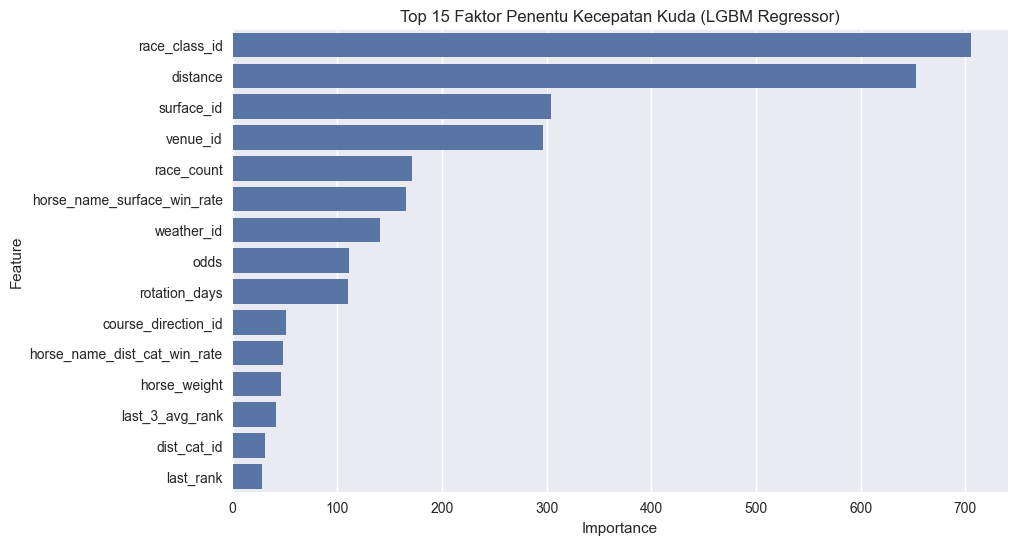

In [6]:
# Ambil model terbaik (misal LGBM)
best_model = models['LGBM']

feature_imp = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': best_model.feature_importances_
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp.sort_values('Importance', ascending=False).head(15))
plt.title('Top 15 Faktor Penentu Kecepatan Kuda (LGBM Regressor)')
plt.show()